# DEVANet: Description-Enhanced Video-Audio Network

In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from scipy.stats import pearsonr
import pickle
import os
import warnings

# Device configuration
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Device: {device}")

# Load preprocessed data
preprocessed_path = "./preprocessed_data"

print("\n" + "=" * 70)
print("LOADING PREPROCESSED MOSI DATASET")
print("=" * 70)

with open(os.path.join(preprocessed_path, 'mosi_preprocessed.pkl'), 'rb') as f:
    df = pickle.load(f)

with open(os.path.join(preprocessed_path, 'dataset_info.pkl'), 'rb') as f:
    dataset_info = pickle.load(f)

print(f"\n✓ Loaded {len(df)} preprocessed samples")
print(f"\n📊 Feature dimensions:")
print(f"  - Text embedding: {dataset_info['text_embedding_dim']}")
print(f"  - Audio MFCC: {dataset_info['audio_mfcc_dim']}")
print(f"  - Visual CNN: {dataset_info['visual_cnn_dim']}")
print(f"  - Audio description: {dataset_info['audio_desc_embedding_dim']}")
print(f"  - Visual description: {dataset_info['visual_desc_embedding_dim']}")

# Extract features
texts = df['text'].tolist()
text_embeddings = df['text_embedding'].tolist()
audio_mfccs = df['audio_mfcc'].tolist()
visual_cnns = df['visual_cnn'].tolist()
audio_desc_embeddings = df['audio_desc_embedding'].tolist()
visual_desc_embeddings = df['visual_desc_embedding'].tolist()
label_list = df['sentiment_label'].tolist()
labels = torch.tensor(label_list).float().to(device)

print(f"\n📊 Dataset statistics:")
print(f"  - Total samples: {len(texts)}")
print(f"  - Labels: min={min(label_list):.2f}, max={max(label_list):.2f}, mean={np.mean(label_list):.2f}")
print(f"  - Positive: {sum(1 for l in label_list if l > 0)}, ",
      f"Negative: {sum(1 for l in label_list if l < 0)}, ",
      f"Neutral: {sum(1 for l in label_list if l == 0)}")

print("\n" + "=" * 70)

🖥️  Device: mps

LOADING PREPROCESSED MOSI DATASET

✓ Loaded 500 preprocessed samples

📊 Feature dimensions:
  - Text embedding: 768
  - Audio MFCC: 20
  - Visual CNN: 8
  - Audio description: 768
  - Visual description: 768

📊 Dataset statistics:
  - Total samples: 500
  - Labels: min=-2.80, max=3.00, mean=0.42
  - Positive: 280,  Negative: 197,  Neutral: 23



In [26]:
# ============================================================================
# 2. MODEL ARCHITECTURE - TEXT ENCODER
# ============================================================================

# Initialize BERT (used by TextEncoder)
from torch import nn
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

# Freeze BERT for speed (can be toggled)
for p in bert.parameters():
    p.requires_grad = False
bert.eval()

class TextEncoder(nn.Module):
    """Enhanced text encoder with special learnable token and transformer layers."""
    def __init__(self, bert_dim=768, num_output_tokens=8, nhead=8):
        super().__init__()
        self.bert_dim = bert_dim
        self.T = num_output_tokens
        
        # Special learnable token E_m
        self.special_token = nn.Parameter(torch.randn(1, 1, bert_dim))
        
        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=bert_dim,
            nhead=nhead,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings without gradients (faster)
        with torch.no_grad():
            bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
            bert_sequence = bert_output.last_hidden_state  # [B, seq_len, 768]
        
        batch_size = bert_sequence.size(0)
        
        # Prepend special token
        special_token_expanded = self.special_token.expand(batch_size, -1, -1)
        sequence_with_token = torch.cat([special_token_expanded, bert_sequence], dim=1)
        
        # Apply transformer encoder (trainable)
        enhanced_sequence = self.transformer_encoder(sequence_with_token)
        
        # Keep first T tokens (or pad if needed)
        if enhanced_sequence.size(1) >= self.T:
            output_sequence = enhanced_sequence[:, :self.T, :]
        else:
            padding_size = self.T - enhanced_sequence.size(1)
            padding = torch.zeros(batch_size, padding_size, self.bert_dim, 
                                device=enhanced_sequence.device)
            output_sequence = torch.cat([enhanced_sequence, padding], dim=1)
        
        return output_sequence

text_encoder = TextEncoder().to(device)
print("✓ TextEncoder initialized (BERT frozen for speed)")


✓ TextEncoder initialized (BERT frozen for speed)


In [27]:
# ============================================================================
# 3. MODEL ARCHITECTURE - CROSS-MODAL FUSION COMPONENTS
# ============================================================================

class CrossModalAttention(nn.Module):
    """Scaled dot-product attention for text-guided fusion."""
    def __init__(self, dim=768, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        
        self.query_proj = nn.Linear(dim, dim)
        self.key_proj = nn.Linear(dim, dim)
        self.value_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key_value):
        batch_size = query.size(0)
        
        # Multi-head projections
        Q = self.query_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key_proj(key_value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value_proj(key_value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, V)
        
        # Reshape and output projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.dim)
        return self.out_proj(attn_output)


class AudioVisualFeatureProjector(nn.Module):
    """Projects audio/visual features to aligned sequences."""
    def __init__(self, input_dim, output_dim=768, num_tokens=8):
        super().__init__()
        self.num_tokens = num_tokens
        self.projection = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim * num_tokens)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        projected = self.projection(x)
        return projected.view(batch_size, self.num_tokens, -1)


class MFU(nn.Module):
    """Minor Fusion Unit - text-guided residual fusion."""
    def __init__(self, dim=768, num_heads=8):
        super().__init__()
        self.cross_attn_audio = CrossModalAttention(dim=dim, num_heads=num_heads)
        self.cross_attn_visual = CrossModalAttention(dim=dim, num_heads=num_heads)
        
        # Learnable fusion weights
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta = nn.Parameter(torch.tensor(0.5))
        self.norm = nn.LayerNorm(dim)
        
    def forward(self, X_t, X_a, X_v, prev_fusion=None):
        audio_attended = self.cross_attn_audio(query=X_a, key_value=X_t)
        visual_attended = self.cross_attn_visual(query=X_v, key_value=X_t)
        
        if prev_fusion is None:
            prev_fusion = X_t
        
        fusion = prev_fusion + self.alpha * audio_attended + self.beta * visual_attended
        return self.norm(fusion)

print("✓ Cross-modal fusion components initialized")


✓ Cross-modal fusion components initialized


In [28]:
# ============================================================================
# 4. BASELINE MODEL
# ============================================================================

class BaselineModel(nn.Module):
    """Simple concatenation-based multimodal fusion."""
    def __init__(self, text_dim=768, audio_dim=20, visual_dim=8):
        super().__init__()
        self.fusion_head = nn.Sequential(
            nn.Linear(text_dim + audio_dim + visual_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        
    def forward(self, text_emb, audio_features, visual_features):
        # Ensure 2D inputs
        if text_emb.dim() == 1:
            text_emb = text_emb.unsqueeze(0)
        if audio_features.dim() == 1:
            audio_features = audio_features.unsqueeze(0)
        if visual_features.dim() == 1:
            visual_features = visual_features.unsqueeze(0)
        
        fused = torch.cat([text_emb, audio_features, visual_features], dim=-1)
        return self.fusion_head(fused)

baseline_model = BaselineModel().to(device)
print(f"✓ Baseline Model - Parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")


✓ Baseline Model - Parameters: 220,545


In [29]:
# ============================================================================
# 6. FAST CONFIG + TENSORS + DATALOADERS
# ============================================================================

from torch.utils.data import DataLoader, TensorDataset

torch.set_num_threads(4)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FAST_BATCH_SIZE = 64
NUM_WORKERS = 0  # set >0 if using CUDA and enough CPU cores
USE_AMP = (device == "cuda")

# Stack features into tensors (CPU first)
text_emb_all = torch.tensor(np.stack(text_embeddings), dtype=torch.float32)
audio_all = torch.tensor(np.stack(audio_mfccs), dtype=torch.float32)
visual_all = torch.tensor(np.stack(visual_cnns), dtype=torch.float32)
audio_desc_all = torch.tensor(np.stack(audio_desc_embeddings), dtype=torch.float32)
visual_desc_all = torch.tensor(np.stack(visual_desc_embeddings), dtype=torch.float32)
labels_all = torch.tensor(label_list, dtype=torch.float32)

# Tokenize all texts once
tokens_all = tokenizer(
    texts,
    return_tensors='pt',
    padding='max_length',
    truncation=True,
    max_length=32
)
input_ids_all = tokens_all['input_ids']
attention_mask_all = tokens_all['attention_mask']

# Train/test split (reuse same split as before)
train_size = int(0.8 * len(texts))
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(texts)))

# TensorDatasets
train_base = TensorDataset(
    text_emb_all[train_indices],
    audio_all[train_indices],
    visual_all[train_indices],
    labels_all[train_indices]
)

test_base = TensorDataset(
    text_emb_all[test_indices],
    audio_all[test_indices],
    visual_all[test_indices],
    labels_all[test_indices]
)

train_deva = TensorDataset(
    input_ids_all[train_indices],
    attention_mask_all[train_indices],
    audio_all[train_indices],
    visual_all[train_indices],
    audio_desc_all[train_indices],
    visual_desc_all[train_indices],
    labels_all[train_indices]
)

test_deva = TensorDataset(
    input_ids_all[test_indices],
    attention_mask_all[test_indices],
    audio_all[test_indices],
    visual_all[test_indices],
    audio_desc_all[test_indices],
    visual_desc_all[test_indices],
    labels_all[test_indices]
)

# DataLoaders
train_loader_base = DataLoader(train_base, batch_size=FAST_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader_base = DataLoader(test_base, batch_size=FAST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_loader_deva = DataLoader(train_deva, batch_size=FAST_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader_deva = DataLoader(test_deva, batch_size=FAST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"✓ Dataloaders ready | batch={FAST_BATCH_SIZE} | train={len(train_indices)} | test={len(test_indices)}")


✓ Dataloaders ready | batch=64 | train=400 | test=100


In [30]:
# ============================================================================
# 5. DEVANet MODEL
# ============================================================================

class DEVANet(nn.Module):
    """Description-Enhanced multimodal fusion with gated descriptions."""
    def __init__(self, text_encoder, audio_mfcc_dim=20, visual_cnn_dim=8,
                 hidden_dim=768, num_tokens=8, num_mfu_layers=1, num_heads=8):
        super().__init__()
        
        self.text_encoder = text_encoder
        self.hidden_dim = hidden_dim
        
        # Feature projectors
        self.audio_projector = AudioVisualFeatureProjector(audio_mfcc_dim, hidden_dim, num_tokens)
        self.visual_projector = AudioVisualFeatureProjector(visual_cnn_dim, hidden_dim, num_tokens)
        
        # MFU stack
        self.mfu_layers = nn.ModuleList([
            MFU(dim=hidden_dim, num_heads=num_heads) 
            for _ in range(num_mfu_layers)
        ])
        
        # Gating mechanism for descriptions
        self.audio_desc_gate = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim), nn.Sigmoid())
        self.audio_desc_transform = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(), nn.LayerNorm(hidden_dim)
        )
        
        self.visual_desc_gate = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim), nn.Sigmoid())
        self.visual_desc_transform = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(), nn.LayerNorm(hidden_dim)
        )
        
        # Prediction head
        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        
    def forward(self, text_input_ids, text_attention_mask, 
                audio_features, visual_features, D_a=None, D_v=None):
        # 1. Text encoding
        X_t = self.text_encoder(text_input_ids, text_attention_mask)
        
        # 2. Audio/visual projection
        X_a = self.audio_projector(audio_features)
        X_v = self.visual_projector(visual_features)
        
        # 3. Description integration with gating
        if D_a is not None:
            X_a_mean = X_a.mean(dim=1)
            D_a = D_a.squeeze(1) if D_a.dim() > 2 else D_a
            gate = self.audio_desc_gate(torch.cat([X_a_mean, D_a], dim=-1))
            enhanced_audio = gate * self.audio_desc_transform(D_a)
            X_a = X_a + enhanced_audio.unsqueeze(1)
        
        if D_v is not None:
            X_v_mean = X_v.mean(dim=1)
            D_v = D_v.squeeze(1) if D_v.dim() > 2 else D_v
            gate = self.visual_desc_gate(torch.cat([X_v_mean, D_v], dim=-1))
            enhanced_visual = gate * self.visual_desc_transform(D_v)
            X_v = X_v + enhanced_visual.unsqueeze(1)
        
        # 4. Progressive fusion
        fusion = X_t
        for mfu_layer in self.mfu_layers:
            fusion = mfu_layer(X_t, X_a, X_v, prev_fusion=fusion)
        
        # 5. Prediction
        pooled_features = fusion.mean(dim=1)
        return self.prediction_head(pooled_features)


In [31]:
# ============================================================================
# 6. EVALUATION METRICS
# ============================================================================

def evaluate_metrics(labels, preds):
    """Calculate academic metrics: Acc-2, F1, MAE, Correlation."""
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
    
    labels = labels.flatten()
    preds = preds.flatten()
    
    # Binary accuracy (threshold at 0)
    labels_binary = (labels > 0).astype(int)
    preds_binary = (preds > 0).astype(int)
    acc_2 = accuracy_score(labels_binary, preds_binary)
    
    # F1 score
    f1 = f1_score(labels_binary, preds_binary, average='weighted', zero_division=0)
    
    # MAE
    mae = mean_absolute_error(labels, preds)
    
    # Pearson correlation
    if len(labels) > 1 and np.std(labels) > 1e-8 and np.std(preds) > 1e-8:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                corr, _ = pearsonr(labels, preds)
        except:
            corr = 0.0
    else:
        corr = 0.0
    
    return {'Acc-2': acc_2, 'F1': f1, 'MAE': mae, 'Corr': corr}

def print_metrics(metrics, title="Metrics"):
    print(f"\n{'='*70}\n{title:^70}\n{'='*70}")
    print(f"  Acc-2 (Binary Accuracy)    : {metrics['Acc-2']:.4f}")
    print(f"  F1-Score (Weighted)        : {metrics['F1']:.4f}")
    print(f"  MAE (Mean Absolute Error)  : {metrics['MAE']:.4f}")
    print(f"  Corr (Pearson Correlation) : {metrics['Corr']:.4f}")
    print("="*70)

print("✓ Evaluation metrics ready")


✓ Evaluation metrics ready


In [32]:
# ============================================================================
# 7. TRAIN BASELINE MODEL (batched)
# ============================================================================

from torch.optim import Adam

baseline_optimizer = Adam(baseline_model.parameters(), lr=1e-3, weight_decay=1e-5)
baseline_loss_fn = nn.MSELoss()
num_epochs = 30  # reduced for faster runs

baseline_losses = []
baseline_metrics_history = []

print("\n" + "="*70)
print("TRAINING BASELINE MODEL (BATCHED)")
print("="*70)

for epoch in range(num_epochs):
    baseline_model.train()
    epoch_loss = 0.0
    all_preds, all_labels = [], []

    for text_emb, audio_mfcc, visual_cnn, y in train_loader_base:
        text_emb = text_emb.to(device)
        audio_mfcc = audio_mfcc.to(device)
        visual_cnn = visual_cnn.to(device)
        y = y.to(device)

        pred = baseline_model(text_emb, audio_mfcc, visual_cnn).squeeze(-1)
        loss = baseline_loss_fn(pred, y)

        baseline_optimizer.zero_grad()
        loss.backward()
        baseline_optimizer.step()

        batch_size = y.size(0)
        epoch_loss += loss.item() * batch_size
        all_preds.extend(pred.detach().cpu().tolist())
        all_labels.extend(y.detach().cpu().tolist())

    avg_loss = epoch_loss / len(train_indices)
    baseline_losses.append(avg_loss)

    # Evaluation
    baseline_model.eval()
    test_preds, test_labels_list = [], []
    with torch.no_grad():
        for text_emb, audio_mfcc, visual_cnn, y in test_loader_base:
            text_emb = text_emb.to(device)
            audio_mfcc = audio_mfcc.to(device)
            visual_cnn = visual_cnn.to(device)
            y = y.to(device)

            pred = baseline_model(text_emb, audio_mfcc, visual_cnn).squeeze(-1)
            test_preds.extend(pred.detach().cpu().tolist())
            test_labels_list.extend(y.detach().cpu().tolist())

    test_metrics = evaluate_metrics(np.array(test_labels_list), np.array(test_preds))
    baseline_metrics_history.append(test_metrics)

    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:3d}/{num_epochs} | Loss: {avg_loss:.4f} | "
              f"Acc-2: {test_metrics['Acc-2']:.3f} | MAE: {test_metrics['MAE']:.3f}")

print_metrics(test_metrics, "BASELINE - FINAL TEST METRICS")



TRAINING BASELINE MODEL (BATCHED)
Epoch   0/30 | Loss: 3.0831 | Acc-2: 0.470 | MAE: 1.372
Epoch   5/30 | Loss: 1.6829 | Acc-2: 0.450 | MAE: 1.378
Epoch   0/30 | Loss: 3.0831 | Acc-2: 0.470 | MAE: 1.372
Epoch   5/30 | Loss: 1.6829 | Acc-2: 0.450 | MAE: 1.378
Epoch  10/30 | Loss: 1.2509 | Acc-2: 0.580 | MAE: 1.176
Epoch  10/30 | Loss: 1.2509 | Acc-2: 0.580 | MAE: 1.176
Epoch  15/30 | Loss: 0.9778 | Acc-2: 0.600 | MAE: 1.079
Epoch  20/30 | Loss: 0.8912 | Acc-2: 0.670 | MAE: 0.972
Epoch  15/30 | Loss: 0.9778 | Acc-2: 0.600 | MAE: 1.079
Epoch  20/30 | Loss: 0.8912 | Acc-2: 0.670 | MAE: 0.972
Epoch  25/30 | Loss: 0.5211 | Acc-2: 0.720 | MAE: 0.966
Epoch  29/30 | Loss: 0.5357 | Acc-2: 0.630 | MAE: 1.057

                    BASELINE - FINAL TEST METRICS                     
  Acc-2 (Binary Accuracy)    : 0.6300
  F1-Score (Weighted)        : 0.5713
  MAE (Mean Absolute Error)  : 1.0573
  Corr (Pearson Correlation) : 0.6678
Epoch  25/30 | Loss: 0.5211 | Acc-2: 0.720 | MAE: 0.966
Epoch  29/30 

In [33]:
# ============================================================================
# 8. TRAIN DEVA MODEL (batched + AMP)
# ============================================================================

from torch.optim import Adam

deva_model = DEVANet(
    text_encoder=text_encoder,
    audio_mfcc_dim=dataset_info['audio_mfcc_dim'],
    visual_cnn_dim=dataset_info['visual_cnn_dim'],
    hidden_dim=768,
    num_tokens=8,
    num_mfu_layers=1,
    num_heads=8
).to(device)

deva_optimizer = Adam(deva_model.parameters(), lr=5e-4, weight_decay=1e-5)
deva_loss_fn = nn.MSELoss()

deva_losses = []
deva_metrics_history = []

print("\n" + "="*70)
print("TRAINING DEVA MODEL (BATCHED)")
print("="*70)

if USE_AMP:
    scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    deva_model.train()
    epoch_loss = 0.0

    for input_ids, attention_mask, audio_mfcc, visual_cnn, D_a, D_v, y in train_loader_deva:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        audio_mfcc = audio_mfcc.to(device)
        visual_cnn = visual_cnn.to(device)
        D_a = D_a.to(device)
        D_v = D_v.to(device)
        y = y.to(device)

        deva_optimizer.zero_grad()
        if USE_AMP:
            with torch.cuda.amp.autocast():
                pred = deva_model(input_ids, attention_mask, audio_mfcc, visual_cnn, D_a=D_a, D_v=D_v).squeeze(-1)
                loss = deva_loss_fn(pred, y)
            scaler.scale(loss).backward()
            scaler.step(deva_optimizer)
            scaler.update()
        else:
            pred = deva_model(input_ids, attention_mask, audio_mfcc, visual_cnn, D_a=D_a, D_v=D_v).squeeze(-1)
            loss = deva_loss_fn(pred, y)
            loss.backward()
            deva_optimizer.step()

        epoch_loss += loss.item() * y.size(0)

    avg_loss = epoch_loss / len(train_indices)
    deva_losses.append(avg_loss)

    # Evaluation
    deva_model.eval()
    test_preds, test_labels_list = [], []
    with torch.no_grad():
        for input_ids, attention_mask, audio_mfcc, visual_cnn, D_a, D_v, y in test_loader_deva:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            audio_mfcc = audio_mfcc.to(device)
            visual_cnn = visual_cnn.to(device)
            D_a = D_a.to(device)
            D_v = D_v.to(device)
            y = y.to(device)

            if USE_AMP:
                with torch.cuda.amp.autocast():
                    pred = deva_model(input_ids, attention_mask, audio_mfcc, visual_cnn, D_a=D_a, D_v=D_v).squeeze(-1)
            else:
                pred = deva_model(input_ids, attention_mask, audio_mfcc, visual_cnn, D_a=D_a, D_v=D_v).squeeze(-1)

            test_preds.extend(pred.detach().cpu().tolist())
            test_labels_list.extend(y.detach().cpu().tolist())

    test_metrics = evaluate_metrics(np.array(test_labels_list), np.array(test_preds))
    deva_metrics_history.append(test_metrics)

    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:3d}/{num_epochs} | Loss: {avg_loss:.4f} | "
              f"Acc-2: {test_metrics['Acc-2']:.3f} | MAE: {test_metrics['MAE']:.3f}")

print_metrics(test_metrics, "DEVA - FINAL TEST METRICS")



TRAINING DEVA MODEL (BATCHED)
Epoch   0/30 | Loss: 2.0798 | Acc-2: 0.620 | MAE: 1.145
Epoch   0/30 | Loss: 2.0798 | Acc-2: 0.620 | MAE: 1.145
Epoch   5/30 | Loss: 0.6592 | Acc-2: 0.760 | MAE: 0.834
Epoch   5/30 | Loss: 0.6592 | Acc-2: 0.760 | MAE: 0.834
Epoch  10/30 | Loss: 0.2102 | Acc-2: 0.730 | MAE: 0.772
Epoch  10/30 | Loss: 0.2102 | Acc-2: 0.730 | MAE: 0.772
Epoch  15/30 | Loss: 0.1369 | Acc-2: 0.770 | MAE: 0.778
Epoch  15/30 | Loss: 0.1369 | Acc-2: 0.770 | MAE: 0.778
Epoch  20/30 | Loss: 0.1084 | Acc-2: 0.760 | MAE: 0.752
Epoch  20/30 | Loss: 0.1084 | Acc-2: 0.760 | MAE: 0.752
Epoch  25/30 | Loss: 0.0902 | Acc-2: 0.750 | MAE: 0.787
Epoch  25/30 | Loss: 0.0902 | Acc-2: 0.750 | MAE: 0.787
Epoch  29/30 | Loss: 0.0760 | Acc-2: 0.760 | MAE: 0.753

                      DEVA - FINAL TEST METRICS                       
  Acc-2 (Binary Accuracy)    : 0.7600
  F1-Score (Weighted)        : 0.7552
  MAE (Mean Absolute Error)  : 0.7525
  Corr (Pearson Correlation) : 0.7394
Epoch  29/30 | Lo

In [34]:
# ============================================================================
# 9. MODEL COMPARISON
# ============================================================================

print("\n" + "="*70)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*70)
print()

# Get final epoch metrics
baseline_final = baseline_metrics_history[-1]
deva_final = deva_metrics_history[-1]

print(f"{'Metric':<15} {'Baseline':<15} {'DEVA':<15} {'Improvement':<15}")
print("-" * 60)

# Map friendly names to metric keys
metric_keys = {
    'Acc-2': 'Acc-2',
    'F1-Score': 'F1',  # evaluate_metrics uses 'F1'
    'MAE': 'MAE',
    'Corr': 'Corr'
}

for display_name in ['Acc-2', 'F1-Score', 'MAE', 'Corr']:
    key = metric_keys[display_name]
    baseline_val = baseline_final[key]
    deva_val = deva_final[key]
    
    # For MAE, lower is better
    if key == 'MAE':
        improvement = ((baseline_val - deva_val) / baseline_val) * 100 if baseline_val != 0 else 0.0
        sign = "↓" if improvement > 0 else "↑"
    else:
        denom = abs(baseline_val) if abs(baseline_val) > 1e-12 else 1.0
        improvement = ((deva_val - baseline_val) / denom) * 100
        sign = "↑" if improvement > 0 else "↓"
    
    print(f"{display_name:<15} {baseline_val:>7.4f}       {deva_val:>7.4f}       "
          f"{sign} {abs(improvement):>5.1f}%")

print("=" * 70)



MODEL COMPARISON - FINAL RESULTS

Metric          Baseline        DEVA            Improvement    
------------------------------------------------------------
Acc-2            0.6300        0.7600       ↑  20.6%
F1-Score         0.5713        0.7552       ↑  32.2%
MAE              1.0573        0.7525       ↓  28.8%
Corr             0.6678        0.7394       ↑  10.7%


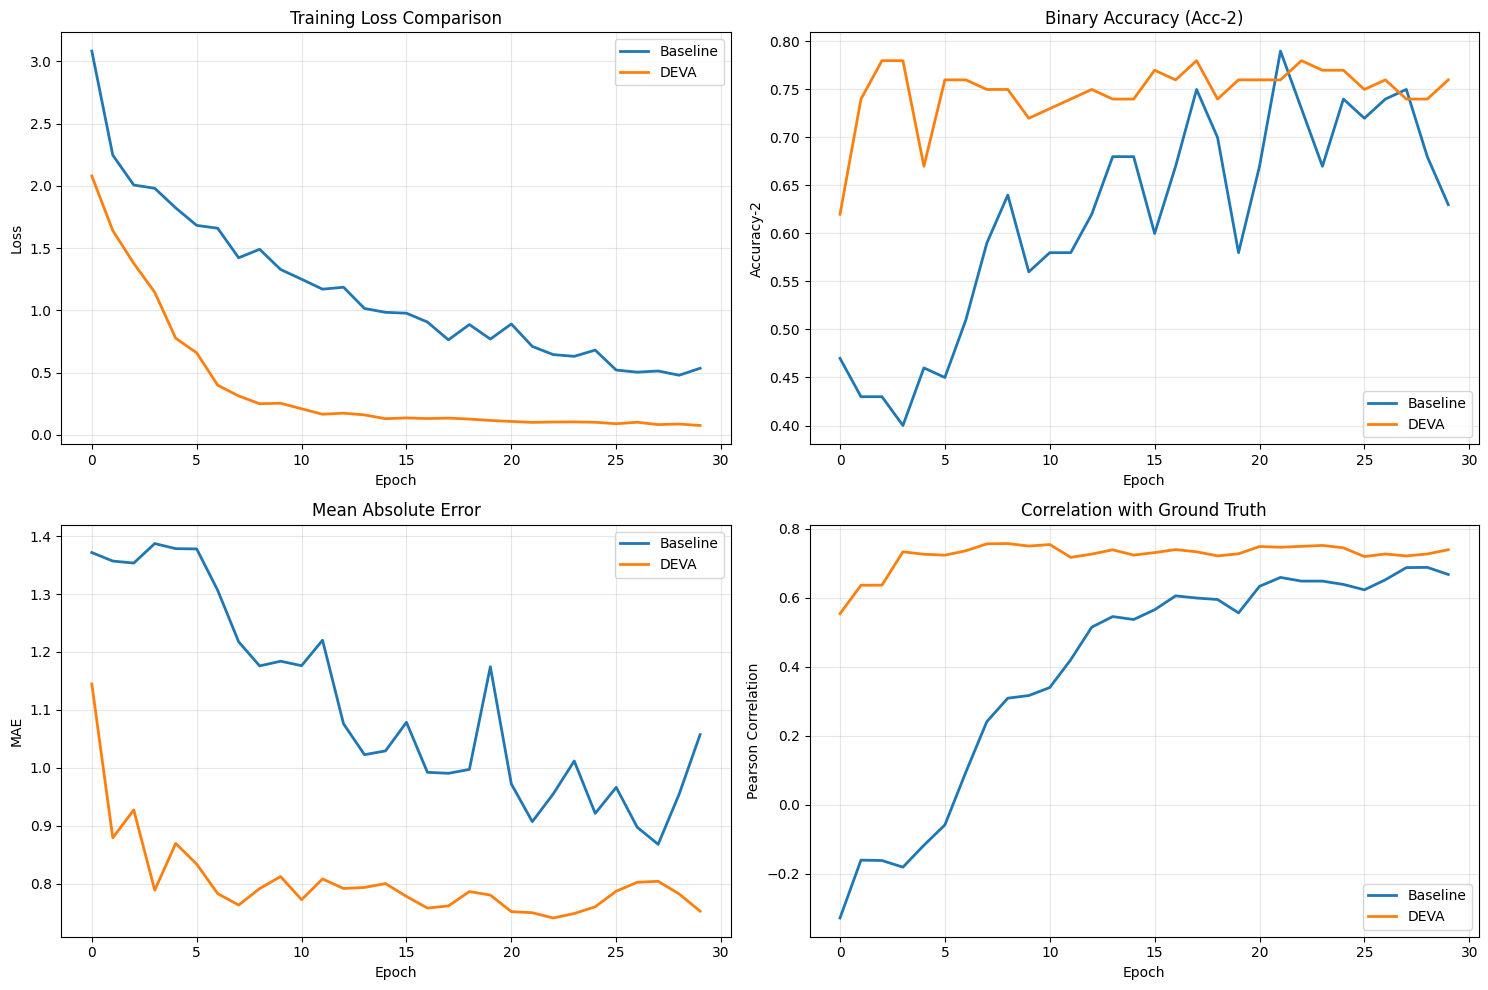

In [35]:
# ============================================================================
# 10. VISUALIZATION - TRAINING CURVES
# ============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Extract metrics over epochs
baseline_acc2 = [m['Acc-2'] for m in baseline_metrics_history]
deva_acc2 = [m['Acc-2'] for m in deva_metrics_history]
baseline_mae = [m['MAE'] for m in baseline_metrics_history]
deva_mae = [m['MAE'] for m in deva_metrics_history]
baseline_corr = [m['Corr'] for m in baseline_metrics_history]
deva_corr = [m['Corr'] for m in deva_metrics_history]

epochs = range(num_epochs)

# Plot 1: Training Loss
axes[0, 0].plot(epochs, baseline_losses, label='Baseline', linewidth=2)
axes[0, 0].plot(epochs, deva_losses, label='DEVA', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Acc-2
axes[0, 1].plot(epochs, baseline_acc2, label='Baseline', linewidth=2)
axes[0, 1].plot(epochs, deva_acc2, label='DEVA', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy-2')
axes[0, 1].set_title('Binary Accuracy (Acc-2)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: MAE
axes[1, 0].plot(epochs, baseline_mae, label='Baseline', linewidth=2)
axes[1, 0].plot(epochs, deva_mae, label='DEVA', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Mean Absolute Error')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Correlation
axes[1, 1].plot(epochs, baseline_corr, label='Baseline', linewidth=2)
axes[1, 1].plot(epochs, deva_corr, label='DEVA', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Pearson Correlation')
axes[1, 1].set_title('Correlation with Ground Truth')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [36]:
# ============================================================================
# 13. SAVE MODELS FOR EXTERNAL USE
# ============================================================================

# This cell saves:
# - DEVA model weights (state_dict)
# - Baseline model weights (state_dict)
# - JSON configs with the hyperparameters needed to reconstruct the models
# - A copy of dataset_info for reference
#
# Output directory: ./models

import os, json, pickle, datetime
from pathlib import Path

models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# ----------------------------
# Save Baseline model
# ----------------------------
baseline_state_path = models_dir / f"baseline_state_dict_{timestamp}.pt"
baseline_cfg_path = models_dir / f"baseline_config_{timestamp}.json"

baseline_config = {
    "model_name": "BaselineModel",
    "text_dim": 768,  # matches TextEncoder/emb dims used
    "audio_dim": int(dataset_info.get("audio_mfcc_dim", 20)),
    "visual_dim": int(dataset_info.get("visual_cnn_dim", 8)),
}

torch.save(baseline_model.state_dict(), baseline_state_path)
with open(baseline_cfg_path, "w") as f:
    json.dump(baseline_config, f, indent=2)

print(f"✓ Saved Baseline state_dict -> {baseline_state_path}")
print(f"✓ Saved Baseline config     -> {baseline_cfg_path}")

# ----------------------------
# Save DEVA model
# ----------------------------
deva_state_path = models_dir / f"deva_state_dict_{timestamp}.pt"
deva_cfg_path = models_dir / f"deva_config_{timestamp}.json"

# These hyperparameters must match how the model was constructed in Cell 8
# If you change them above, update them here too.
deva_config = {
    "model_name": "DEVANet",
    "bert_model": "bert-base-uncased",
    "tokenizer": "bert-base-uncased",
    "audio_mfcc_dim": int(dataset_info.get("audio_mfcc_dim", 20)),
    "visual_cnn_dim": int(dataset_info.get("visual_cnn_dim", 8)),
    "hidden_dim": 768,
    "num_tokens": 8,
    "num_mfu_layers": 1,
    "num_heads": 8,
    "text_max_len": 32
}

torch.save(deva_model.state_dict(), deva_state_path)
with open(deva_cfg_path, "w") as f:
    json.dump(deva_config, f, indent=2)

print(f"✓ Saved DEVA state_dict     -> {deva_state_path}")
print(f"✓ Saved DEVA config         -> {deva_cfg_path}")

# ----------------------------
# Save dataset_info copy
# ----------------------------
info_copy_path = models_dir / f"dataset_info_{timestamp}.pkl"
with open(info_copy_path, "wb") as f:
    pickle.dump(dataset_info, f)
print(f"✓ Saved dataset_info        -> {info_copy_path}")


✓ Saved Baseline state_dict -> models/baseline_state_dict_20251202-163759.pt
✓ Saved Baseline config     -> models/baseline_config_20251202-163759.json
✓ Saved DEVA state_dict     -> models/deva_state_dict_20251202-163759.pt
✓ Saved DEVA config         -> models/deva_config_20251202-163759.json
✓ Saved dataset_info        -> models/dataset_info_20251202-163759.pkl
✓ Saved DEVA state_dict     -> models/deva_state_dict_20251202-163759.pt
✓ Saved DEVA config         -> models/deva_config_20251202-163759.json
✓ Saved dataset_info        -> models/dataset_info_20251202-163759.pkl
